# p4. K-Means Clustering and Gaussian Mixture Model


- 기수: 12기

- 이름: 이영일

- 작성자: 11기 김정우


_본 과제는 Dongha Lee의 24-1 Machine Learning (AAI3120) 과제와 Songkuk Kim의 Programming for Data Science (IIT3308) 과제에 참조하였음을 밝힙니다._


## 1. K-Means Clustering


본 과제 문제에서는 간단한 K-Means Clustering에 관한 내용을 다루고 있다.

직접 K-Means Clustering 과정에서의 다양한 연산들을 구현해보며, 원리에 대해 이해하는데 도움이 되기 바란다.

<hr/>


### 01. Setting


In [1]:
import numpy as np
import scipy.io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
mat = scipy.io.loadmat('/content/drive/MyDrive/kaggle/Regression+SVM+비지도학습/data/clustering_data.mat')
mat.keys()
X = mat['X']

initial_centroids = np.array([[3, 3],[6, 2],[8, 5]])
K = initial_centroids.shape[0]

In [6]:
initial_centroids.shape

(3, 2)

In [13]:
X.shape

(300, 2)

### 02. Computing Centroids


K-Means Clustering에서 핵심이 되는 Centroid 할당을 위한 과정입니다.

입력받은 모든 sample들에 대해서, 가장 가까운 centroid를 찾고, 해당 idx를 저장합니다.


In [11]:
def find_closest_centroid(X, centroids):

    idx = np.zeros((X.shape[0],1))

    for i in range(X.shape[0]):

        distances = np.linalg.norm(X[i] - centroids, axis=1)

        # 가장 가까운 중심점의 인덱스를 찾음
        closest_centroid_index = np.argmin(distances)

        # 해당 인덱스를 idx 배열에 저장
        idx[i] = closest_centroid_index

    return idx

아래 코드를 실행하여, 본인이 작성한 코드가 적절한지 확인해볼 수 있습니다.


In [12]:
# compare the answer with the executed results of your code
idx = find_closest_centroid(X, initial_centroids)
print('[YOUR CODE] Closest centroids for the first 3 examples:', idx[:3].T)
print('[ANSWER] the closest centroids should be [[1., 3., 2.]]')

[YOUR CODE] Closest centroids for the first 3 examples: [[0. 2. 1.]]
[ANSWER] the closest centroids should be [[1., 3., 2.]]


In [29]:
X[idx.reshape(300) == 1]

array([[6.35257892, 3.2908545 ],
       [4.08164951, 0.87200343],
       [4.72372078, 0.62044136],
       [4.13835915, 1.24780979],
       [4.43152976, 0.54041   ],
       [4.25588482, 0.90643957],
       [4.05386581, 0.53291862],
       [3.95549912, 0.83269299],
       [4.18450011, 0.45356203],
       [4.16911897, 0.20581038],
       [4.37271861, 1.02914092],
       [4.1590816 , 0.61720733],
       [4.27783068, 1.1801368 ],
       [4.30471138, 1.10725995],
       [5.29239452, 0.36873298],
       [6.00506534, 2.72784171],
       [6.05696411, 2.94970433],
       [6.77012767, 3.21411422],
       [5.64034678, 2.69385282],
       [5.63325403, 2.99002339],
       [6.17443157, 3.29026488],
       [7.24694794, 2.96877424],
       [5.58162906, 3.33510375],
       [5.3627205 , 3.14681192],
       [4.70775773, 2.78710869],
       [6.64107248, 3.05998738],
       [6.37473652, 2.56253059],
       [7.28780324, 2.75179885],
       [6.20295231, 2.67856179],
       [5.38736041, 2.26737346],
       [5.

이어서 Centroid 갱신을 위한 계산을 위한 과정입니다.

각 idx에 할당된 sample들에 대해서, 적절한 centroid를 계산하여 반환하는 과정입니다.


In [32]:
def compute_centroids(X, idx, K):

    centroids = np.zeros((K, X.shape[1]))

    for i in range(K):
        centroids[i,:] = np.mean(X[idx.reshape(300) == i], axis = 0)

    return centroids

아래 코드를 실행하여, 본인이 작성한 코드가 적절한지 확인해볼 수 있습니다.


In [33]:
centroids = compute_centroids(X, idx, K)
print("[YOUR CODE RESULT]")
print('Centroids computed after initial finding of closest centroids:\n', centroids)
print()
print("[ANSWER]")
print('Centroids should be: \n[[2.428301 3.157924]\n[5.813503 2.633656]\n[7.119387 3.616684]]')

[YOUR CODE RESULT]
Centroids computed after initial finding of closest centroids:
 [[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]

[ANSWER]
Centroids should be: 
[[2.428301 3.157924]
[5.813503 2.633656]
[7.119387 3.616684]]


### 03. Experiments


In [34]:
def plot_kmeans(X, centroids, previous, idx, K, axes):
    for i, ax in enumerate(axes):
        sns.scatterplot(x=X[:,0], y=X[:,1], hue=idx.ravel(), legend=False, palette=['r', 'g', 'b'], ax=ax)
        if i==0:
            sns.scatterplot(x=centroids[:,0], y=centroids[:,1], marker='X', color='k', legend=False, s=100, ax=ax)
        else:
            sns.scatterplot(x=centroids[:,0], y=centroids[:,1], marker='X', color='k', legend=False, s=100, ax=ax)
        for i in range(centroids.shape[0]):
            ax.plot([centroids[i,0], previous[i,0]], [centroids[i,1], previous[i,1]], '--k');


def run_kmeans(X, initial_centroids, max_iters, plot_progress):

    if plot_progress:
        ncols = 3
        nrows = int(max_iters/ncols)
        if max_iters % ncols > 0:
            nrows = nrows + 1
        fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,nrows*8))
        ax_tuple = list(np.ndindex(nrows,ncols))
        for ax in ax_tuple[max_iters:]:
            axes[ax].set_axis_off()
        ax_tuple = ax_tuple[:max_iters]

    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids

    for i in range(max_iters):
        idx = find_closest_centroid(X, centroids)

        if plot_progress:
            plot_axes = [axes[axi] for axi in ax_tuple[i:]]
            axes[ax_tuple[i]].set_title('K-Means iteration {0}/{1}'.format(i+1, max_iters))
            plot_kmeans(X, centroids, previous_centroids, idx, K, plot_axes)
            previous_centroids = centroids
            previous_ax = plt.gca()
        else:
            print('K-Means iteration {0}/{1}'.format(i+1, max_iters))

        centroids = compute_centroids(X, idx, K)

    if plot_progress:
        plt.show()
    return centroids, idx

Random Initialization을 비롯하여 다양한 Initial Centroid에 따라 달라지는 K-Means의 결과에 대해 확인해보세요!


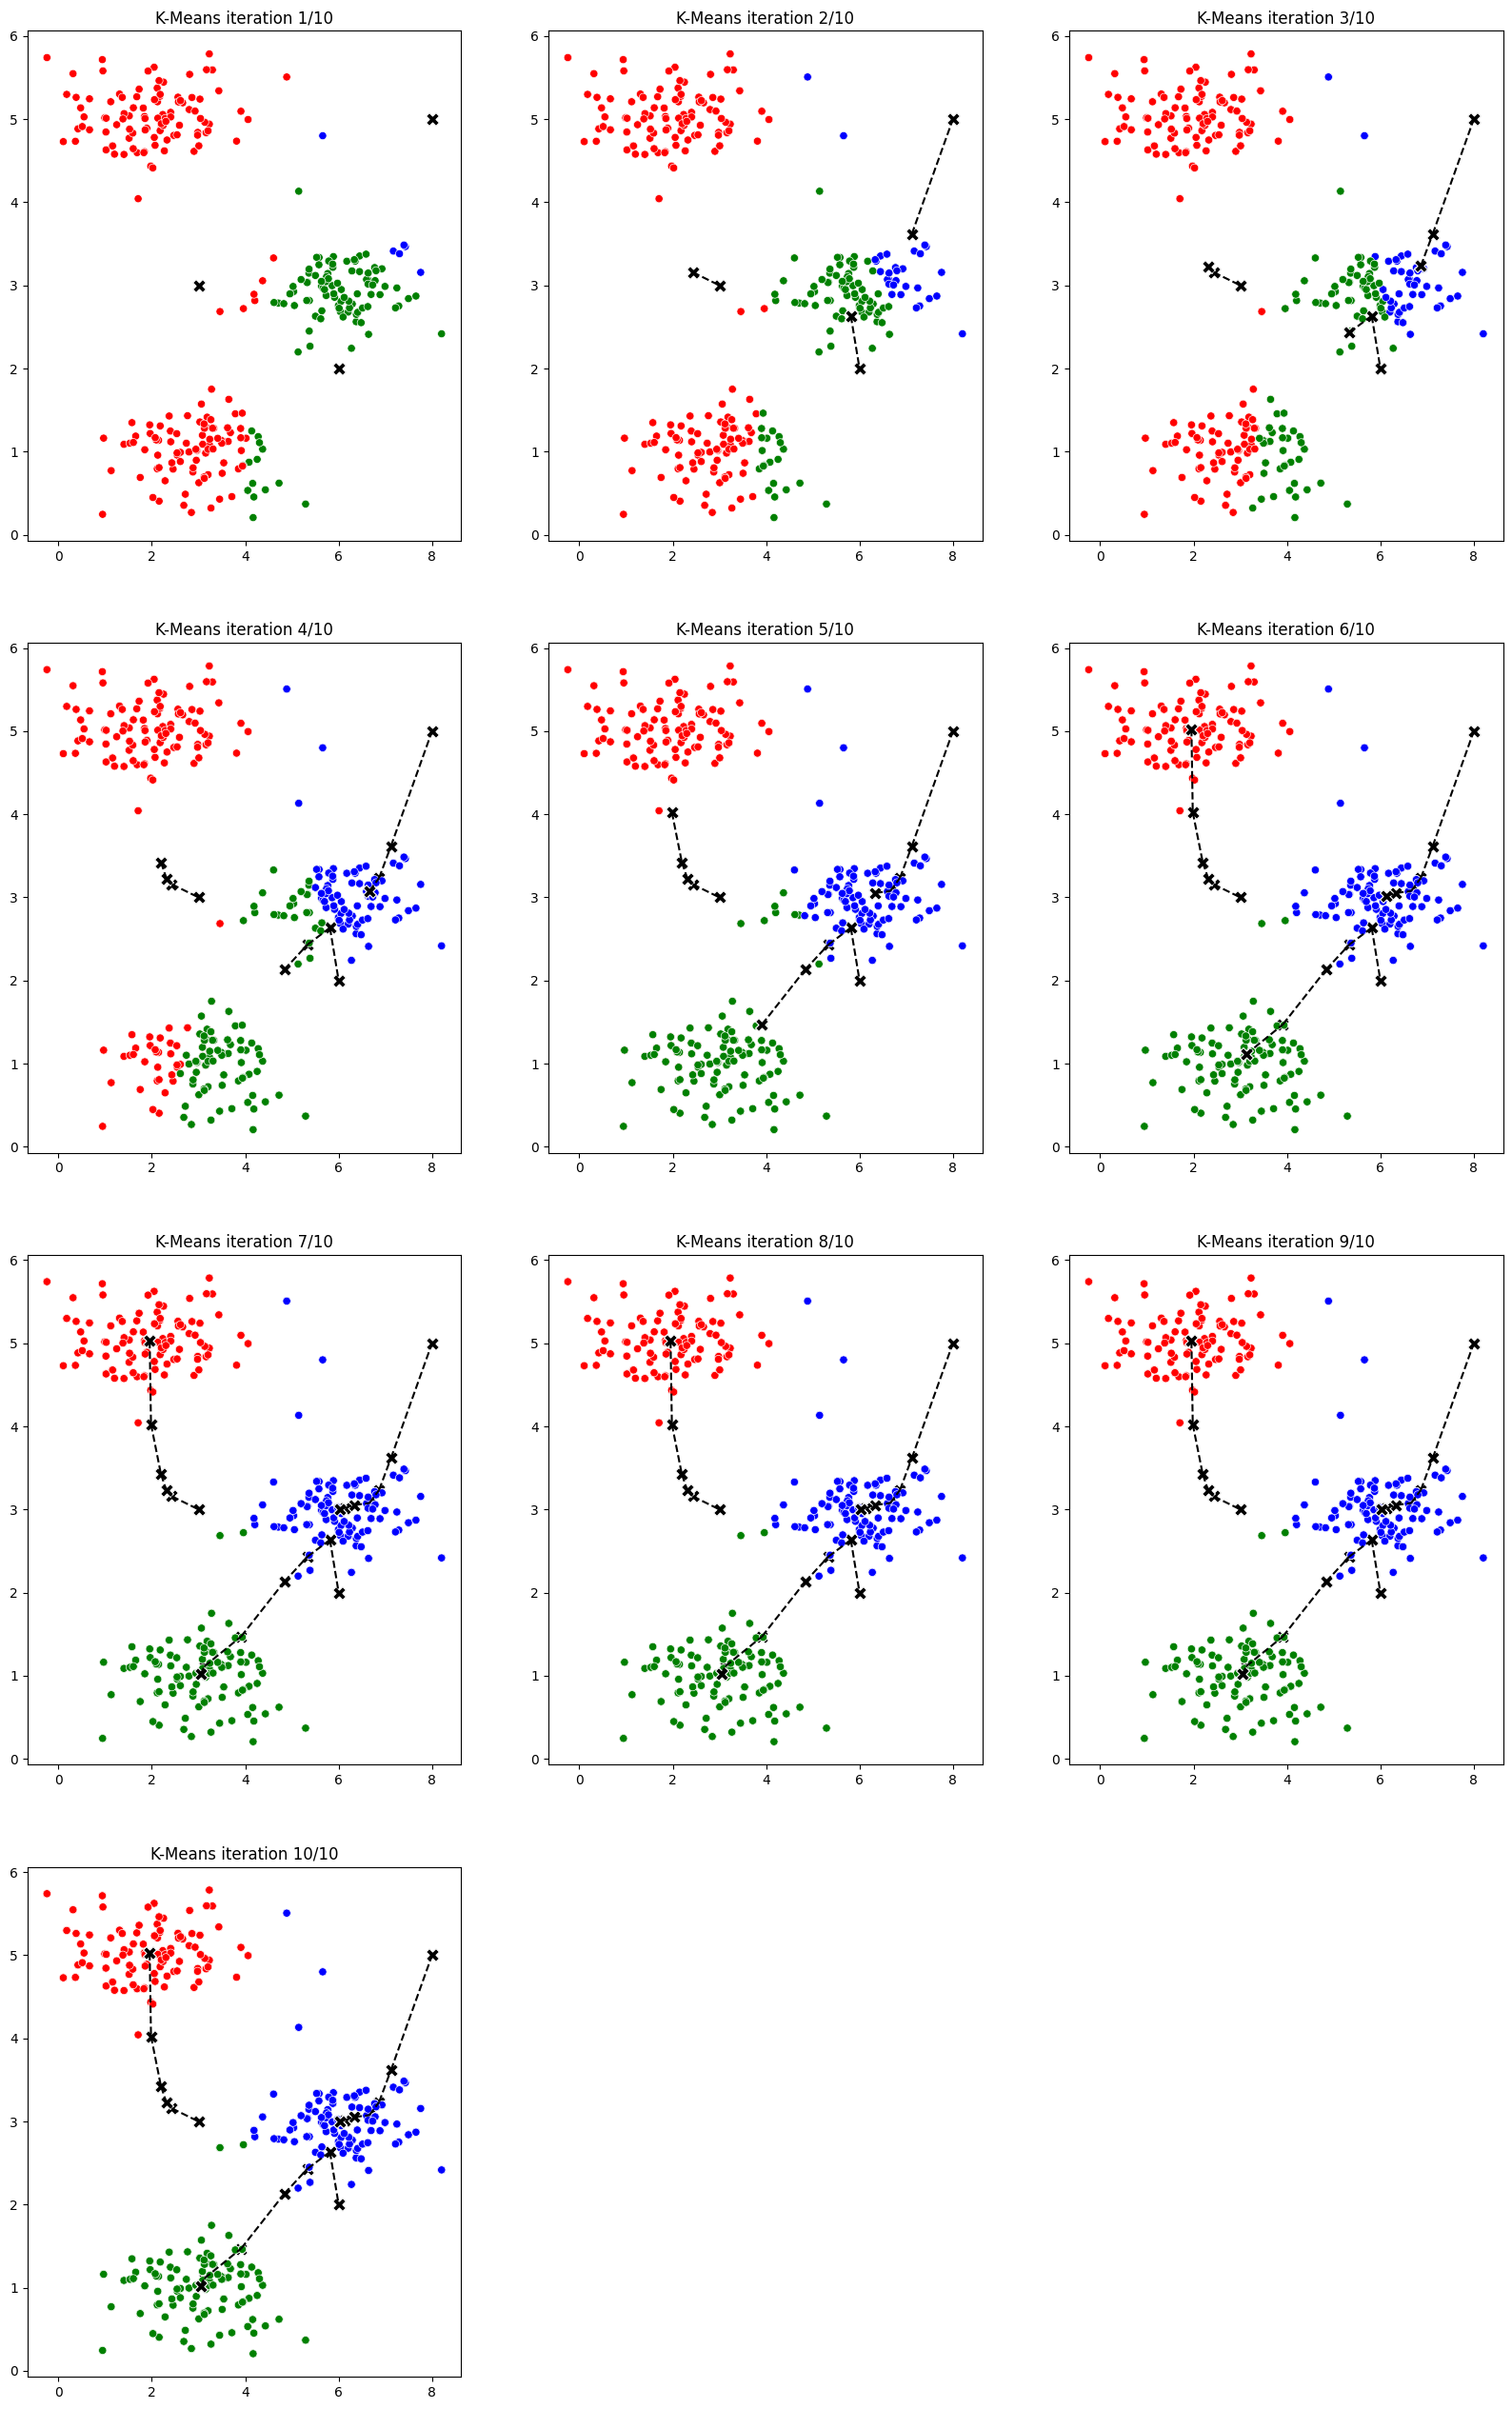

In [35]:
K = 3
max_iters = 10
initial_centroids = np.array([[3, 3],[6, 2],[8, 5]])

centroids, idx = run_kmeans(X, initial_centroids, max_iters, plot_progress=True)

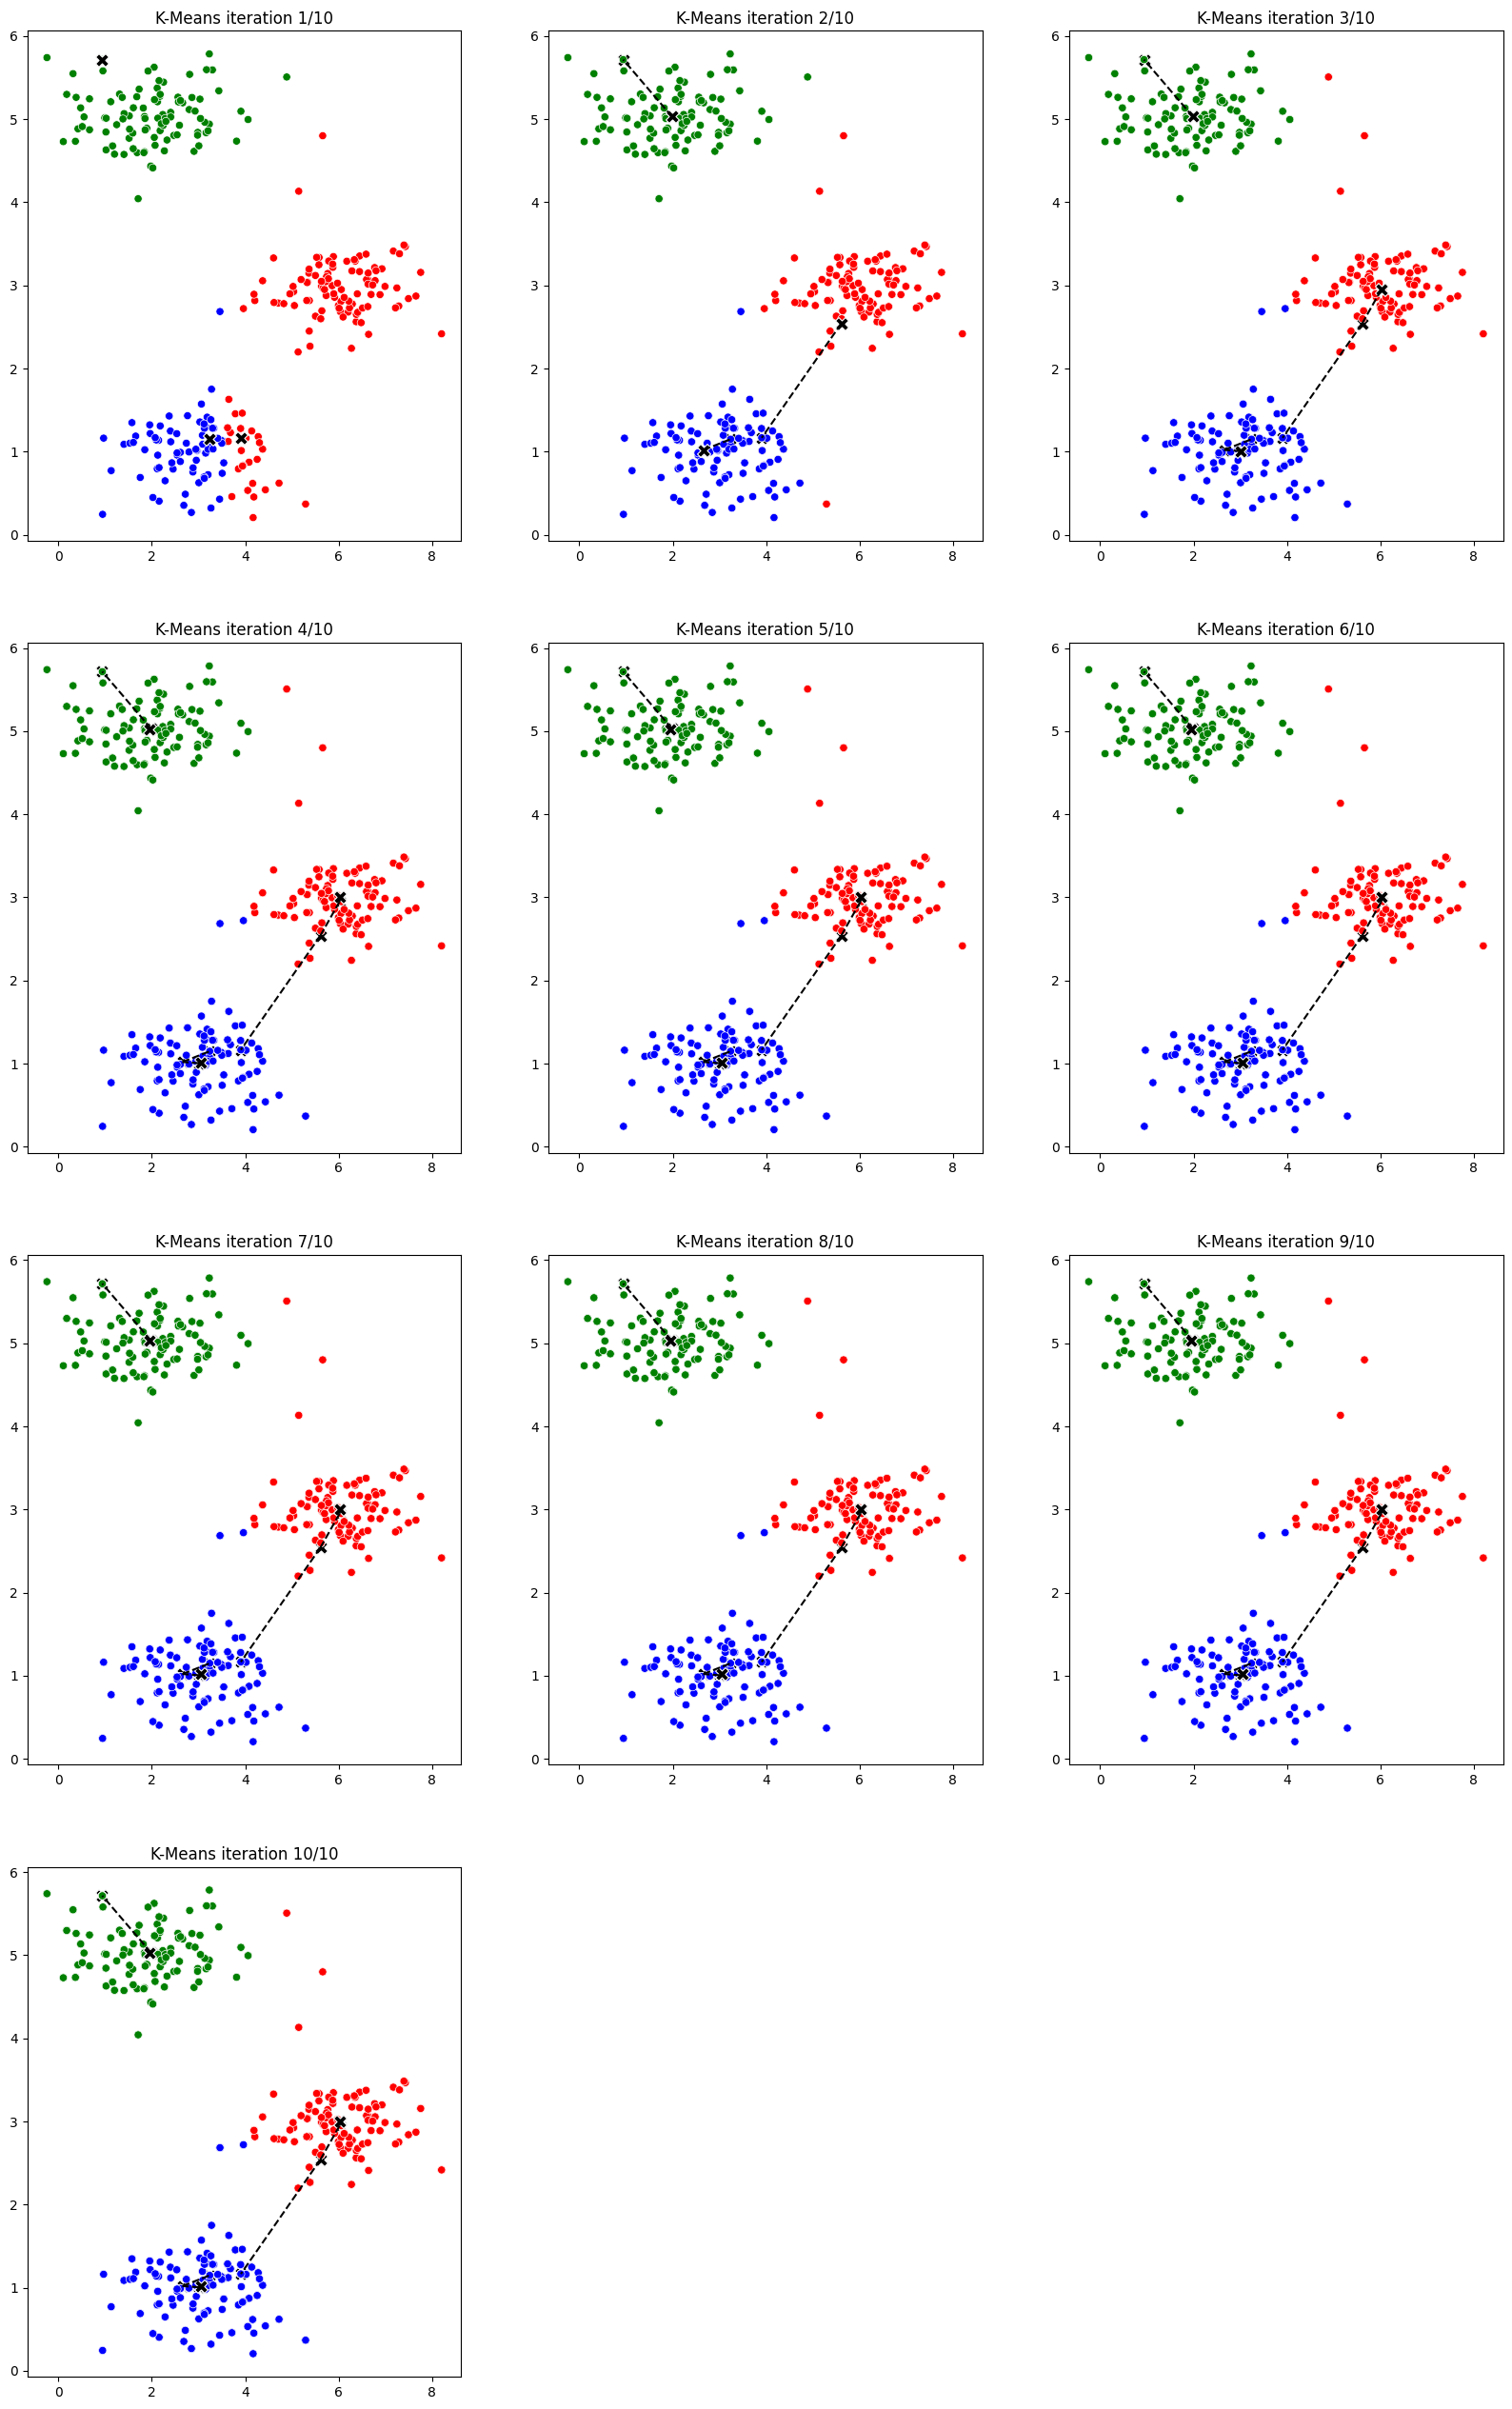

In [36]:
# random initialization
def init_random_centroids(X, K):

    centroids = X[(np.random.choice(X.shape[0], K)), :]
    return centroids

# Set K-Means variables.
K = 3
max_iters = 10

initial_centroids = init_random_centroids(X, K)

# Run K-Means algorithm.
centroids, idx = run_kmeans(X, initial_centroids, max_iters, plot_progress=True)

## 2. Gaussian Mixture Model


본 과제 문제에서는 간단한 Gaussian Mixture Model (GMM)에 관한 내용을 다루고 있다.

**GMM 문제의 경우 구현의 난이도로 인하여 완성된 코드를 제공하고 있으니, 최종적인 Initialize Condition에 따른 실험만 본인이 직접 진행해보기 바랍니다!**

<hr/>


### 01. Setting


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal
from IPython.display import clear_output

import time
from sklearn.cluster import KMeans

In [38]:
# Set random seed
np.random.seed(2024)

### 02. Given Functions


GMM의 경우 기본적으로 Clustering하려는 데이터들이 Gaussian Distribution을 따른다고 가정하고 있다.

그렇기에 실제 존재하는 데이터셋으로 확인하는 것이 아닌, 아래 customized 함수를 통해 직접 데이터셋을 생성해보도록 하자.

<hr/>


In [39]:
def generate_dataset_2d(means, n, isotropic=True):
    """ Generate a 2D dataset from specified Gaussian distributions. """

    K = len(means)  # Number of Gaussian distributions
    covariances = []
    X = []
    y = []

    for i in range(K):
        if i == 0 and isotropic:
            # Make the first Gaussian isotropic if requested.
            cov = np.eye(2)  # Isotropic covariance matrix
        else:
            # Generate a random, elliptic, rotated covariance matrix.
            theta = np.random.uniform(0, 2 * np.pi)  # Random rotation angle
            c, s = np.cos(theta), np.sin(theta)  # Cosine and sine of the rotation angle
            scale = np.random.uniform(0, 3)  # Random scaling factor
            rotation_matrix = np.array([[c, -s], [s, c]])  # Rotation matrix
            scaling_matrix = np.diag([scale, scale / np.random.uniform(1, 2)])  # Scaling matrix, making it more elliptic
            cov = rotation_matrix @ scaling_matrix @ rotation_matrix.T  # Full covariance matrix

        covariances.append(cov)
        mean = means[i]

        # Generate points using the covariance matrix and mean.
        dist = np.random.randn(n, 2)
        dist_transformed = dist @ np.linalg.cholesky(cov).T + mean
        X.append(dist_transformed)
        y.extend([i] * n)

    X = np.concatenate(X)
    y = np.array(y)
    data = np.column_stack((X, y))

    return data, covariances

# Example usage
means = np.array([[0 , 0], [-2, 5], [4, -1]])
data, covariances = generate_dataset_2d(means, n=100, isotropic=True)

print('Dataset Shape:', data.shape)

Dataset Shape: (300, 3)


In [40]:
def Gaussian2D(grid_data, means, covars):
    """Vectorized computation of multivariate normal distribution on grid."""
    n = grid_data.shape[0]
    K = means.shape[0]
    prob = np.zeros((n, K))
    for k in range(K):
        diff = grid_data - means[k]
        inv_cov = np.linalg.inv(covars[k])
        exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
        coef = 1 / np.sqrt((2 * np.pi)**2 * np.linalg.det(covars[k]))
        prob[:, k] = coef * np.exp(exponent)

    return prob

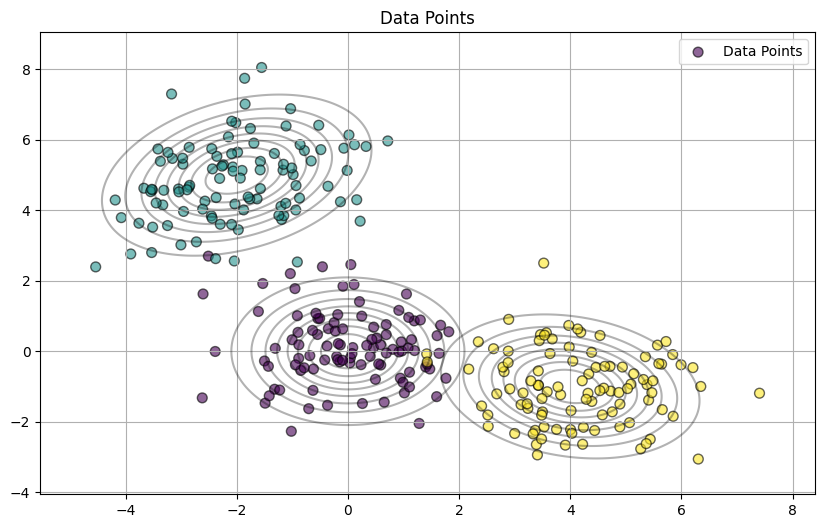

In [41]:
def visualize_data(data, means, covariances):
    """Visualize the data points with separate Gaussian distribution contours for each cluster."""
    fig, ax = plt.subplots(figsize=(10, 6))

    labels = data[:, 2]  # Extract labels from the last column of the dataset
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.6, edgecolor='k', s=50, label='Data Points')

    # Create a grid for contour plots
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    x, y = np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300)
    xx, yy = np.meshgrid(x, y)
    grid_data = np.column_stack([xx.ravel(), yy.ravel()])

    # Draw contours for each Gaussian distribution
    for i in range(len(means)):
        zz = multivariate_normal.pdf(grid_data, mean=means[i], cov=covariances[i]).reshape(xx.shape)
        ax.contour(xx, yy, zz, levels=np.linspace(zz.min(), zz.max(), 10), colors='k', alpha=0.3)

    # Plot formatting
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title('Data Points')
    ax.grid(True)
    ax.legend()
    plt.show()

visualize_data(data, means, covariances)

In [42]:
def DrawGMM(data, assign_history, means_history, vars_history, colors, interval=0.5):
    fig, ax = plt.subplots(figsize=(10, 6))
    max_v = np.ceil(data.max(axis=0))
    min_v = np.floor(data.min(axis=0))
    mrg = (max_v - min_v).max() - (max_v - min_v) + 2
    max_v += mrg / 2
    min_v -= mrg / 2

    x_1 = np.linspace(min_v[0], max_v[0], 100, endpoint=False)
    x_2 = np.linspace(min_v[1], max_v[1], 100, endpoint=False)
    mesh_grid = np.array(np.meshgrid(x_1, x_2))
    grid_data = np.transpose(mesh_grid, (1, 2, 0)).reshape(-1, 2)

    for assign, means, vars in zip(assign_history, means_history, vars_history):
        ax.clear()
        prob_mesh = Gaussian2D(grid_data, means, vars).reshape(x_2.shape[0], x_1.shape[0], -1)
        scatter = ax.scatter(data[:, 0], data[:, 1], c=colors[assign])
        contour = ax.contour(x_1, x_2, np.max(prob_mesh, axis=2))

        ax.set_xlim(min_v[0], max_v[0])
        ax.set_ylim(min_v[1], max_v[1])
        ax.grid(True)
        plt.draw()
        clear_output(wait=True)
        display(fig)
        time.sleep(interval)

    plt.close(fig)

### 03. Gaussian Mixture Model


Gaussian Mixture Model은 크게 E-step과 M-step으로 이루어져서 EM 방식을 통해 동작한다.

이 점을 참고하여 아래 GMM 함수를 직접 실행하고 결과를 확인해보자!


[참고사항]

몇 가지 헷갈릴만한 질문 사항에 대한 답변들입니다!

1. **useProp은 무슨 변수인가요?**

   _클러스터의 가중치를 초기화하는 방법과 관련한 변수입니다. Dirichlet distribution을 사용할지 유무를 결정하게 됩니다._

   _사용하지 않을 경우는 동일한 비율로 가중치를 할당하게 됩니다._

   _(Dirichlet distribution에 대한 설명: https://donghwa-kim.github.io/distributions.html)_

2. **fixedCovars는 무슨 변수인가요?**

   _각 클러스터의 공분산 행렬을 단위행렬으로 고정할지 유무를 결정하는 변수입니다._

   _기본적으로는 False로 선언하여, M-step에서 클러스터의 모양이 데이터에 맞게 변화할 수 있도록 설정합니다._


In [43]:
def GMM(data, means, hard=False, fixedCovars=False, useProp=True):
    N, D = data.shape  # N: number of data points, D: dimension of data points
    K = means.shape[0]  # K: number of clusters

    # Initialize weights
    if useProp:
        weights = np.random.dirichlet(alpha=np.ones(K))
    else:
        weights = np.full(K, 1/K)

    # Initialize covariances
    if fixedCovars:
        covariances = [np.eye(D) for _ in range(K)]
    else:
        covariances = [np.cov(data.T) + np.eye(D) * 1e-6 for _ in range(K)]

    assign_history = []
    means_history = [means.copy()]
    vars_history = [np.array(covariances)]

    convergence = False
    while not convergence:
        # E-step: Calculate responsibilities or hard assignments
        responsibilities = np.zeros((N, K))
        for k in range(K):
            mvn = multivariate_normal(means[k], covariances[k])
            responsibilities[:, k] = mvn.pdf(data) * weights[k]
        sum_responsibilities = responsibilities.sum(axis=1)
        responsibilities /= sum_responsibilities[:, None]

        if hard:
            hard_assignments = np.argmax(responsibilities, axis=1)
            responsibilities = np.zeros_like(responsibilities)
            responsibilities[np.arange(N), hard_assignments] = 1

        assign_history.append(np.argmax(responsibilities, axis=1))

        # M-step: Update means and optionally covariances
        new_means = np.zeros_like(means)
        new_covariances = []
        for k in range(K):
            Nk = responsibilities[:, k].sum()
            new_means[k] = np.dot(responsibilities[:, k], data) / Nk
            if not fixedCovars:
                data_centered = data - new_means[k]
                cov_k = np.dot(responsibilities[:, k] * data_centered.T, data_centered) / Nk
                new_covariances.append(cov_k)
            else:
                new_covariances.append(np.eye(D))

        means_history.append(new_means)
        vars_history.append(new_covariances)

        # Check for convergence (means don't change)
        convergence = np.allclose(means, new_means)
        means = new_means
        covariances = new_covariances

    return assign_history, means_history, vars_history

# Example usage
assign_history, means_history, vars_history = GMM(data[:, :2], means)

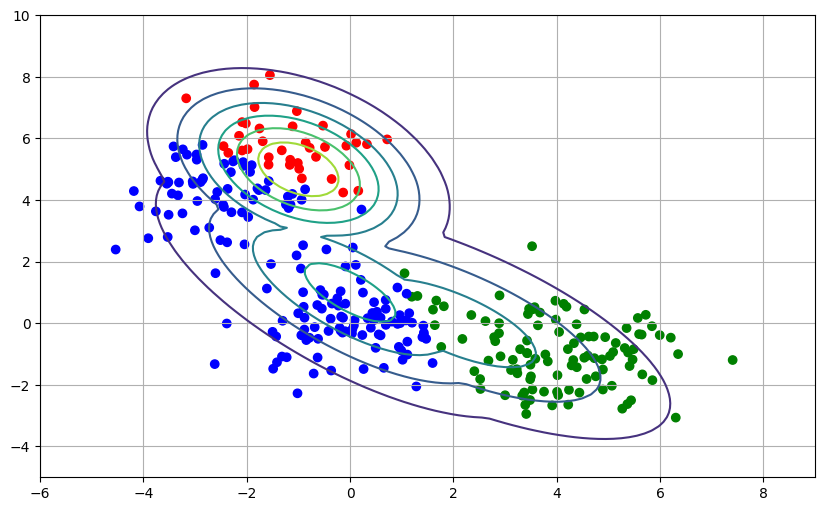

In [44]:
# Example usage
DrawGMM(data, assign_history, means_history, vars_history, colors=np.array(['b', 'r', 'g']), interval=1)

### 04. Experiment


아래와 같은 data1, data2 2가지 데이터셋이 생성되었다고 가정해봅시다.

      1) Randomly Selected Centroids
      2) Manually Defined Centroids
      3) Centroids from K-means

위 3가지 각기다른 centroid 선택 방식에 따라 달라지는 GMM 실행 결과를 직접 확인해보세요!


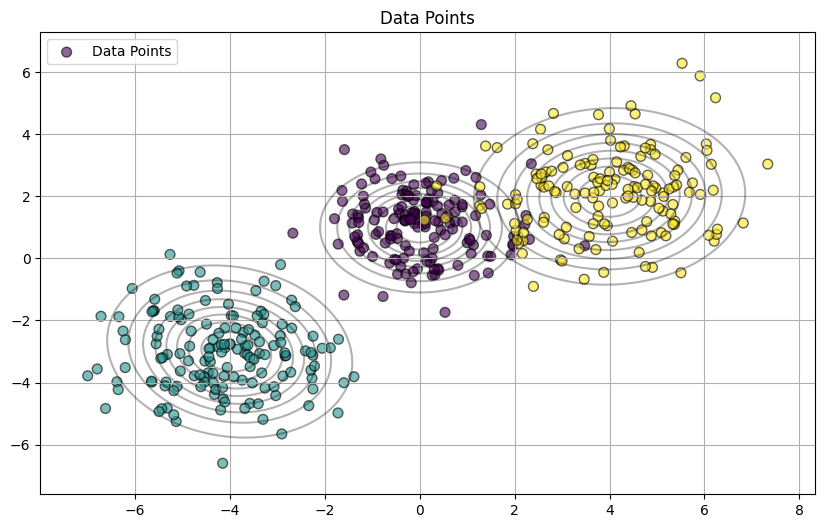

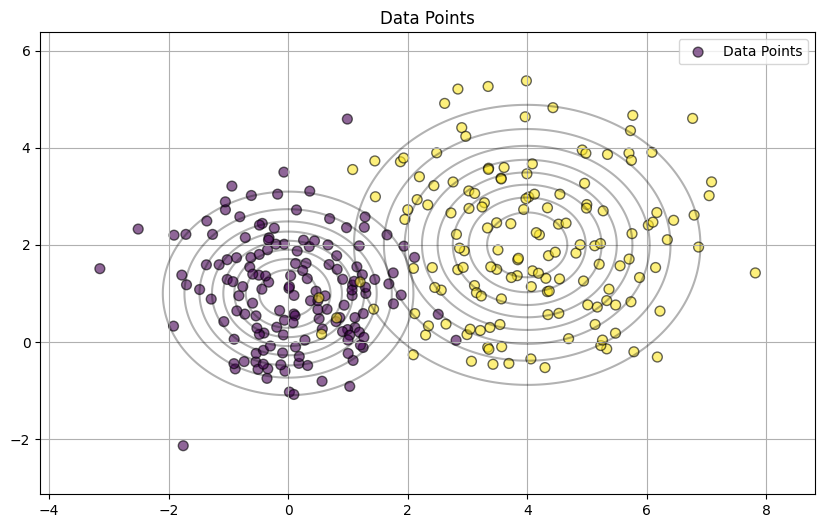

In [45]:
# Dataset generation
means1 = np.array([[0 , 1], [-4, -3], [4, 2]])
data1, covariances1 = generate_dataset_2d(means1, n=150, isotropic=True) # Set isotropic option True

# Visualize generated data
visualize_data(data1, means1, covariances1)

# Dataset generation
means2 = np.array([[0 , 1], [4, 2]])
data2, covariances2 = generate_dataset_2d(means2, n=150, isotropic=True) # Set isotropic option False

# Visualize generated data
visualize_data(data2, means2, covariances2)

In [46]:
# Set three random initial centroids
def initialize_centroids(data, k, method='random'):
    """
      Initial Centroids Selection
      1) Randomly Selected Centroids
      2) Manually Defined Centroids
      3) Centroids from K-means
    """
    if method == 'random':
        indices = np.random.choice(data.shape[0], k, replace=False)
        return data[indices]
    elif method == 'manual':
        if k == 3:
            return np.array([[1, 1], [5, 5], [8, 8]])
        elif k == 2:
            return np.array([[1, 1], [7, 7]])
    elif method == 'kmeans':
        kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
        return kmeans.cluster_centers_
    else:
        return None

In [ ]:
# data1 , random
assign_history11, means_history11, vars_history11 = GMM(data1[:, :2], initialize_centroids(data1[:, :2], k = 3, method = 'random'))
DrawGMM(data1, assign_history11, means_history11, vars_history11,colors=np.array(['b', 'r', 'g']), interval=1)

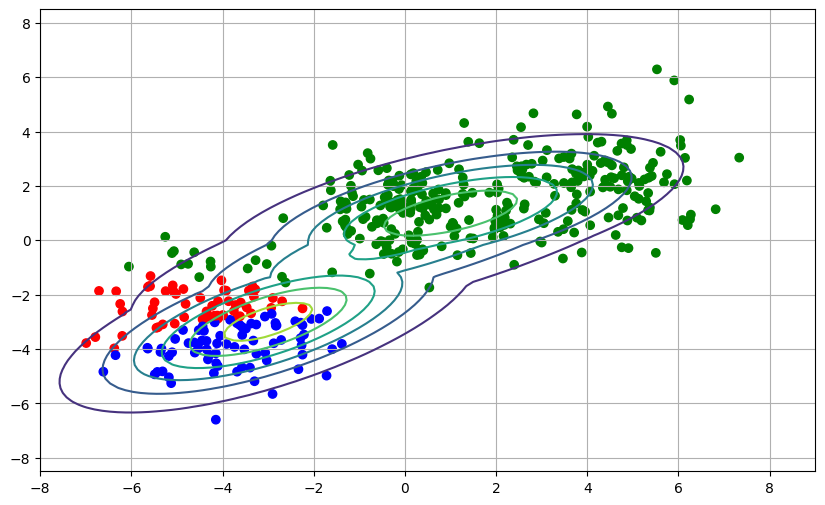

In [50]:
#data1, manual
assign_history12, means_history12, vars_history12 = GMM(data1[:, :2], initialize_centroids(data1[:, :2], k = 3, method = 'manual'))
DrawGMM(data1, assign_history12, means_history12, vars_history12,colors=np.array(['b', 'r', 'g']), interval=1)

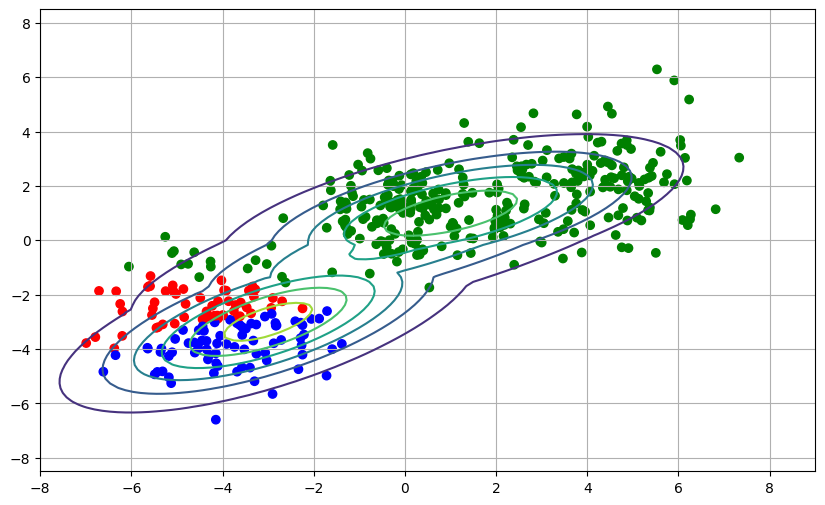

In [51]:
#data1, kmeans
assign_history13, means_history13, vars_history13 = GMM(data1[:, :2], initialize_centroids(data1[:, :2], k = 3, method = 'kmeans'))
DrawGMM(data1, assign_history12, means_history12, vars_history12,colors=np.array(['b', 'r', 'g']), interval=1)

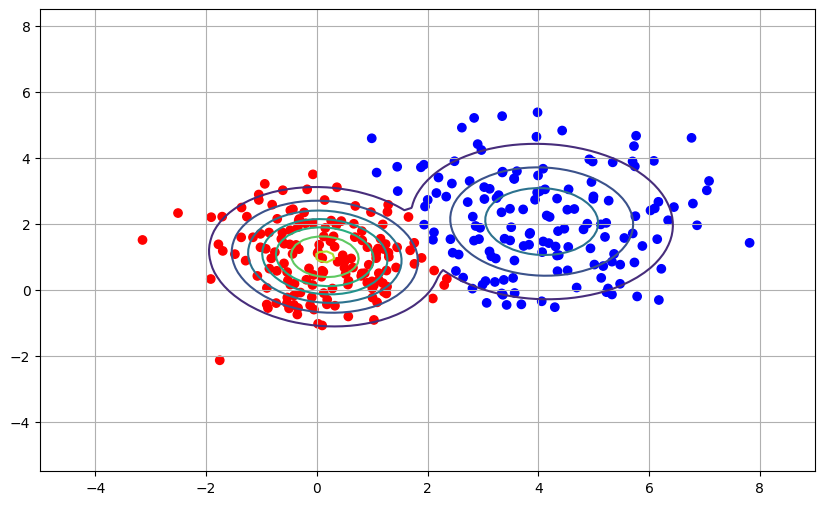

In [53]:
# data2, random
assign_history21, means_history21, vars_history21 = GMM(data2[:, :2], initialize_centroids(data2[:, :2], k = 2, method = 'random'))
DrawGMM(data2, assign_history21, means_history21, vars_history21,colors=np.array(['b', 'r']), interval=1)

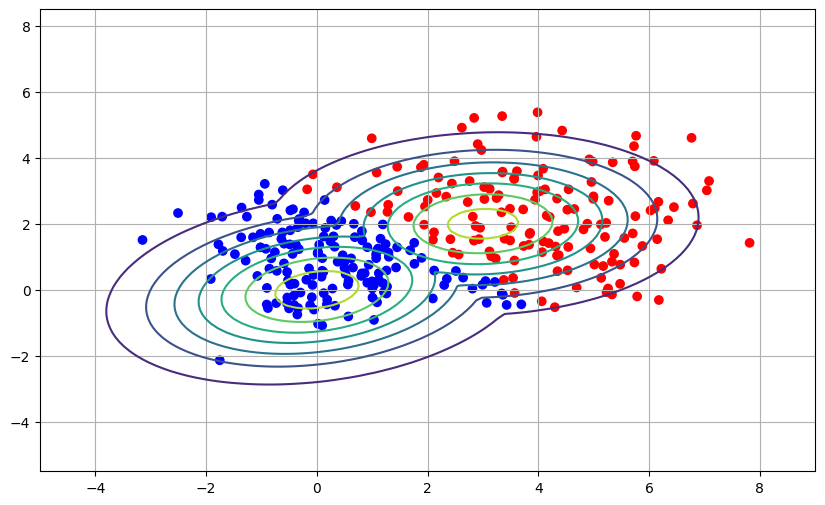

In [54]:
#data2, ma
assign_history22, means_history22, vars_history22 = GMM(data2[:, :2], initialize_centroids(data2[:, :2], k = 2, method = 'manual'))
DrawGMM(data2, assign_history22, means_history22, vars_history22,colors=np.array(['b', 'r']), interval=1)

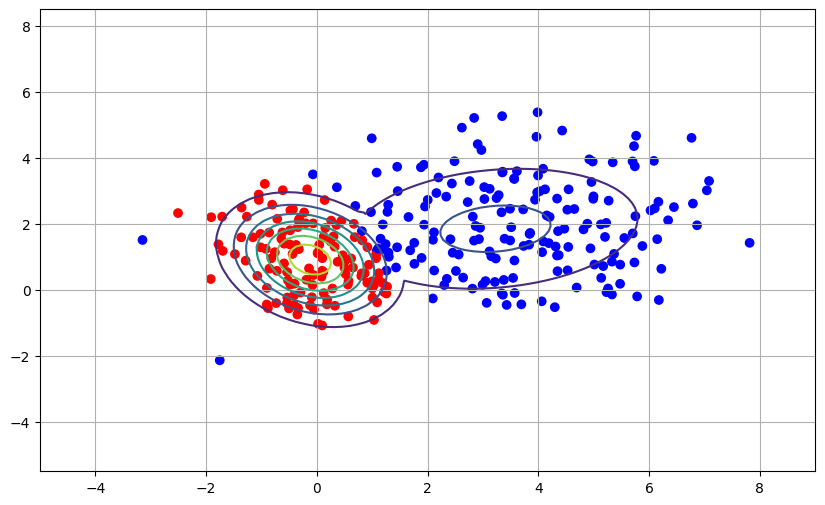

In [55]:
assign_history23, means_history23, vars_history23 = GMM(data2[:, :2], initialize_centroids(data2[:, :2], k = 2, method = 'kmeans'))
DrawGMM(data2, assign_history23, means_history23, vars_history23,colors=np.array(['b', 'r']), interval=1)